In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.models import load_model
from keras.callbacks import CSVLogger

In [2]:
train_df_src = pd.read_csv("../resources/sign_mnist_train.csv")
test_df_src = pd.read_csv("../resources/sign_mnist_test.csv")

In [3]:
train_df_src.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


/Users/eliran.shemtov/DevProjects/hand-gesture-recognition/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

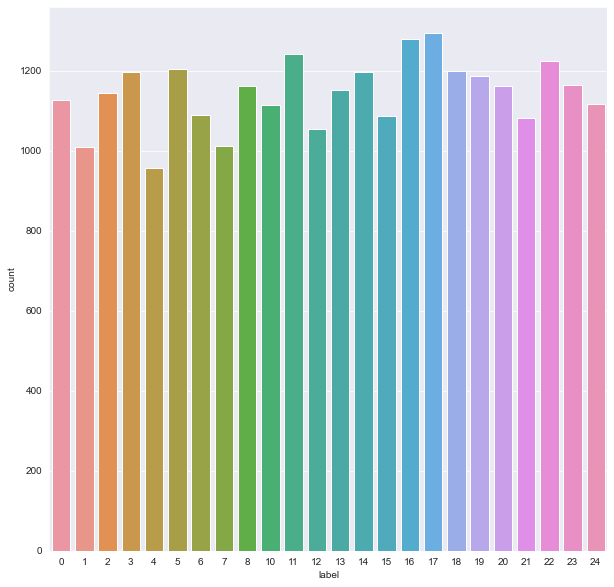

In [4]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df_src['label'])

In [5]:
train_df = train_df_src.copy()
test_df = test_df_src.copy()

train_labels = train_df["label"]
test_labels = test_df["label"]

train_df.drop("label", axis=1, inplace=True)
test_df.drop("label", axis=1, inplace=True)


In [6]:
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.fit_transform(test_labels)

In [7]:
train_values = train_df.values
test_values = test_df.values

In [8]:
train_values = train_values.reshape(-1,28,28,1)
test_values = test_values.reshape(-1,28,28,1)

In [9]:
train_values = train_values / 255
test_values = test_values / 255

In [10]:
train_values, validation_values, train_labels, validation_labels = train_test_split(train_values, train_labels, test_size = 0.3, random_state = 101)

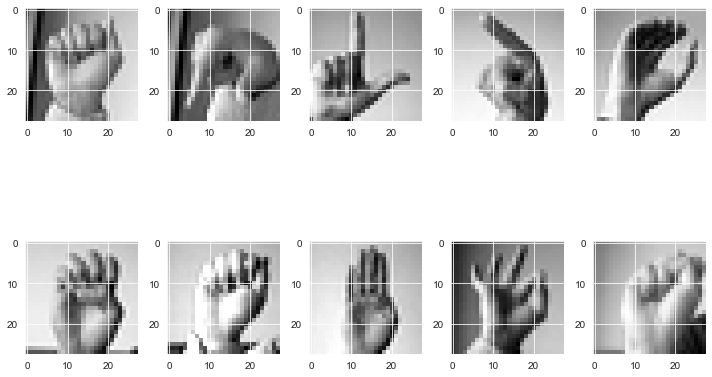

In [11]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(train_values[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_values)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [27]:
TRAINED_MODEL_PATH = "../resources/trained_model.h5"
TRAINING_LOG_PATH = "../resources/training.log"
if os.path.exists(TRAINED_MODEL_PATH):
    print("Found a backup trained model file, will load now...")
    model = load_model(TRAINED_MODEL_PATH)
    print("Loaded model file")
else: 
    model = Sequential()
    model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = 24 , activation = 'softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    
model.summary()

Found a backup trained model file, will load now...
Loaded model file
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
____________________________________________________

In [30]:
if not os.path.exists(TRAINING_LOG_PATH):
    print("Didn't find a training log history, will re-train the model")    
    csv_logger = CSVLogger(TRAINING_LOG_PATH, separator=',', append=False)
    history = model.fit(datagen.flow(train_values, train_labels, batch_size = 128) ,epochs = 20 , validation_data = (validation_values, validation_labels) , callbacks = [learning_rate_reduction ,csv_logger])
    model.save(TRAINED_MODEL_PATH)
    history = history.history
else:
    print("Found a trained model file, will load the training log history")
    history = pd.read_csv(TRAINING_LOG_PATH, sep=',', engine='python')
    

Found a trained model file, will load the training log history


In [29]:
print("Accuracy of the model is - " , model.evaluate(test_values, test_labels)[1]*100 , "%")

225/225 [==============================] - 3s 12ms/step - loss: 0.0016 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


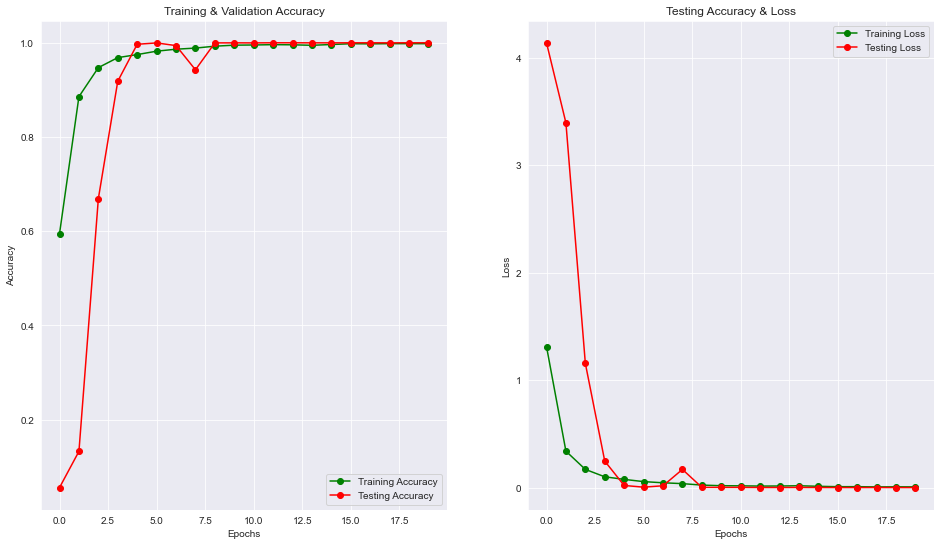

In [31]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(test_df_src["label"], predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [20]:
cm = confusion_matrix(test_df_src["label"],predictions)

In [21]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<AxesSubplot:>

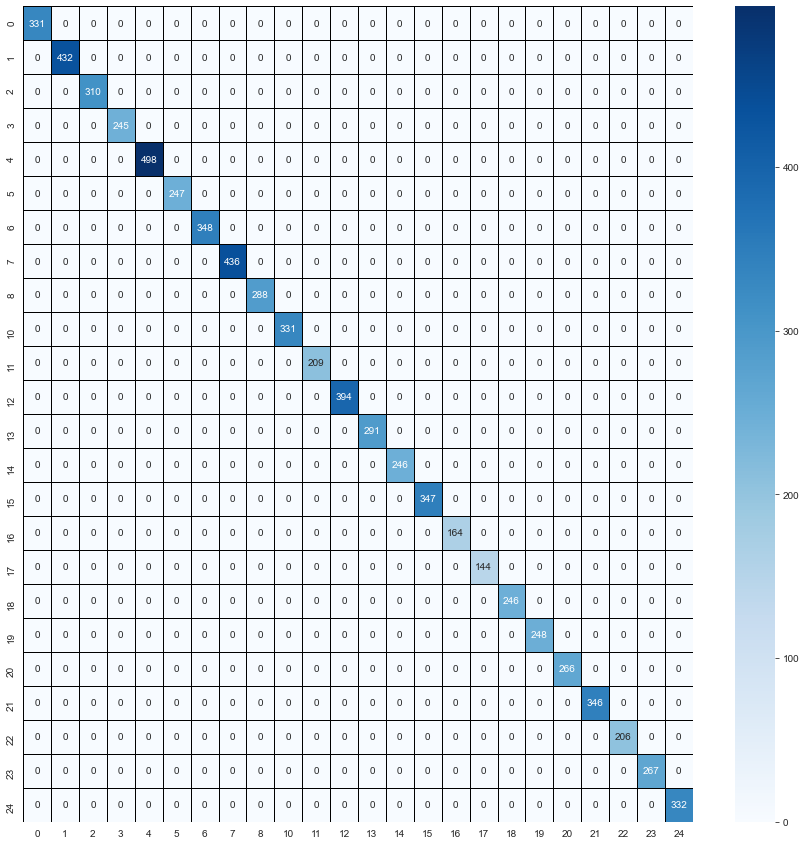

In [22]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

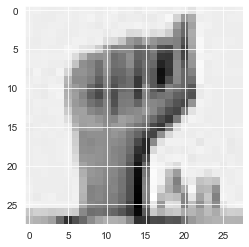

In [48]:
image_a = cv.imread("../resources/A.jpeg", cv.IMREAD_GRAYSCALE)
plt.imshow(image_a, cmap="gray")

In [49]:
a_reshaped = image_a.reshape(-1,28,28,1)
model.predict_classes(a_reshaped)

array([0])